# Double Pendulum: A Study in Deterministic Chaos

## Introduction

The double pendulum is one of the simplest physical systems that exhibits **chaotic behavior**. Despite being governed by deterministic equations, the system displays extreme sensitivity to initial conditions—a hallmark of chaos. This notebook derives the equations of motion, implements a numerical simulation, and visualizes the chaotic dynamics.

## Theoretical Framework

### System Description

Consider two point masses $m_1$ and $m_2$ connected by massless, rigid rods of lengths $L_1$ and $L_2$. The angles $\theta_1$ and $\theta_2$ are measured from the vertical.

### Position Coordinates

The Cartesian coordinates of the two masses are:

**Mass 1:**
$$x_1 = L_1 \sin\theta_1$$
$$y_1 = -L_1 \cos\theta_1$$

**Mass 2:**
$$x_2 = L_1 \sin\theta_1 + L_2 \sin\theta_2$$
$$y_2 = -L_1 \cos\theta_1 - L_2 \cos\theta_2$$

### Lagrangian Mechanics

The kinetic energy $T$ and potential energy $V$ are:

$$T = \frac{1}{2}m_1(\dot{x}_1^2 + \dot{y}_1^2) + \frac{1}{2}m_2(\dot{x}_2^2 + \dot{y}_2^2)$$

$$V = m_1 g y_1 + m_2 g y_2$$

After substitution and simplification:

$$T = \frac{1}{2}(m_1 + m_2)L_1^2\dot{\theta}_1^2 + \frac{1}{2}m_2 L_2^2\dot{\theta}_2^2 + m_2 L_1 L_2 \dot{\theta}_1\dot{\theta}_2\cos(\theta_1 - \theta_2)$$

$$V = -(m_1 + m_2)gL_1\cos\theta_1 - m_2 g L_2\cos\theta_2$$

The Lagrangian is $\mathcal{L} = T - V$.

### Equations of Motion

Applying the Euler-Lagrange equations:

$$\frac{d}{dt}\frac{\partial \mathcal{L}}{\partial \dot{\theta}_i} - \frac{\partial \mathcal{L}}{\partial \theta_i} = 0$$

yields the coupled second-order ODEs. For computational purposes, we express these as first-order equations for the angular velocities $\omega_1 = \dot{\theta}_1$ and $\omega_2 = \dot{\theta}_2$:

$$\dot{\omega}_1 = \frac{-g(2m_1 + m_2)\sin\theta_1 - m_2 g\sin(\theta_1 - 2\theta_2) - 2\sin(\theta_1 - \theta_2)m_2(\omega_2^2 L_2 + \omega_1^2 L_1\cos(\theta_1 - \theta_2))}{L_1(2m_1 + m_2 - m_2\cos(2\theta_1 - 2\theta_2))}$$

$$\dot{\omega}_2 = \frac{2\sin(\theta_1 - \theta_2)((m_1 + m_2)\omega_1^2 L_1 + g(m_1 + m_2)\cos\theta_1 + \omega_2^2 L_2 m_2\cos(\theta_1 - \theta_2))}{L_2(2m_1 + m_2 - m_2\cos(2\theta_1 - 2\theta_2))}$$

### Chaos and Lyapunov Exponents

The system exhibits **sensitive dependence on initial conditions**: two trajectories starting infinitesimally close will diverge exponentially. This is characterized by positive **Lyapunov exponents**. The phase space trajectory of a chaotic double pendulum never repeats, filling a bounded region densely.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Physical parameters
g = 9.81      # gravitational acceleration (m/s^2)
L1 = 1.0      # length of first pendulum (m)
L2 = 1.0      # length of second pendulum (m)
m1 = 1.0      # mass of first bob (kg)
m2 = 1.0      # mass of second bob (kg)

In [2]:
def derivatives(state, t, L1, L2, m1, m2, g):
    """
    Compute the derivatives of the state vector for the double pendulum.
    
    Parameters:
    -----------
    state : array_like
        State vector [theta1, omega1, theta2, omega2]
    t : float
        Time (not used, but required by odeint)
    L1, L2 : float
        Lengths of the pendulum arms
    m1, m2 : float
        Masses of the pendulum bobs
    g : float
        Gravitational acceleration
    
    Returns:
    --------
    dstate : array
        Derivative of state vector
    """
    theta1, omega1, theta2, omega2 = state
    
    delta = theta1 - theta2
    
    # Denominator (common to both equations)
    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    den2 = (L2 / L1) * den1
    
    # Numerators for angular accelerations
    dtheta1 = omega1
    dtheta2 = omega2
    
    domega1 = ((m2 * L1 * omega1**2 * np.sin(delta) * np.cos(delta) +
                m2 * g * np.sin(theta2) * np.cos(delta) +
                m2 * L2 * omega2**2 * np.sin(delta) -
                (m1 + m2) * g * np.sin(theta1)) / den1)
    
    domega2 = ((-m2 * L2 * omega2**2 * np.sin(delta) * np.cos(delta) +
                (m1 + m2) * g * np.sin(theta1) * np.cos(delta) -
                (m1 + m2) * L1 * omega1**2 * np.sin(delta) -
                (m1 + m2) * g * np.sin(theta2)) / den2)
    
    return [dtheta1, domega1, dtheta2, domega2]

In [3]:
def compute_positions(theta1, theta2, L1, L2):
    """
    Compute Cartesian coordinates of both pendulum masses.
    
    Returns:
    --------
    x1, y1, x2, y2 : arrays
        Positions of mass 1 and mass 2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    
    return x1, y1, x2, y2

## Numerical Simulation

We now integrate the equations of motion using `scipy.integrate.odeint`. To demonstrate chaotic sensitivity, we simulate two pendulums with nearly identical initial conditions (differing by only $0.001$ radians in $\theta_1$).

In [4]:
# Time array
t_max = 20.0
dt = 0.01
t = np.arange(0, t_max, dt)

# Initial conditions [theta1, omega1, theta2, omega2]
# Starting from rest with both pendulums displaced
state0_1 = [np.pi/2, 0, np.pi/2, 0]           # First pendulum
state0_2 = [np.pi/2 + 0.001, 0, np.pi/2, 0]   # Second pendulum (tiny perturbation)

# Integrate the ODEs
solution1 = odeint(derivatives, state0_1, t, args=(L1, L2, m1, m2, g))
solution2 = odeint(derivatives, state0_2, t, args=(L1, L2, m1, m2, g))

# Extract angles
theta1_1, omega1_1, theta2_1, omega2_1 = solution1.T
theta1_2, omega1_2, theta2_2, omega2_2 = solution2.T

# Compute positions
x1_1, y1_1, x2_1, y2_1 = compute_positions(theta1_1, theta2_1, L1, L2)
x1_2, y1_2, x2_2, y2_2 = compute_positions(theta1_2, theta2_2, L1, L2)

print(f"Simulation completed: {len(t)} time steps")
print(f"Initial angle difference: {abs(state0_1[0] - state0_2[0]):.4f} rad")

Simulation completed: 2000 time steps
Initial angle difference: 0.0010 rad


## Visualization of Chaotic Behavior

The following figure demonstrates the hallmarks of chaos in the double pendulum system:

1. **Trajectory divergence**: Two nearly identical initial conditions lead to completely different paths
2. **Phase space structure**: The phase portrait shows the complex, non-repeating nature of the motion
3. **Quantified divergence**: The separation between trajectories grows exponentially

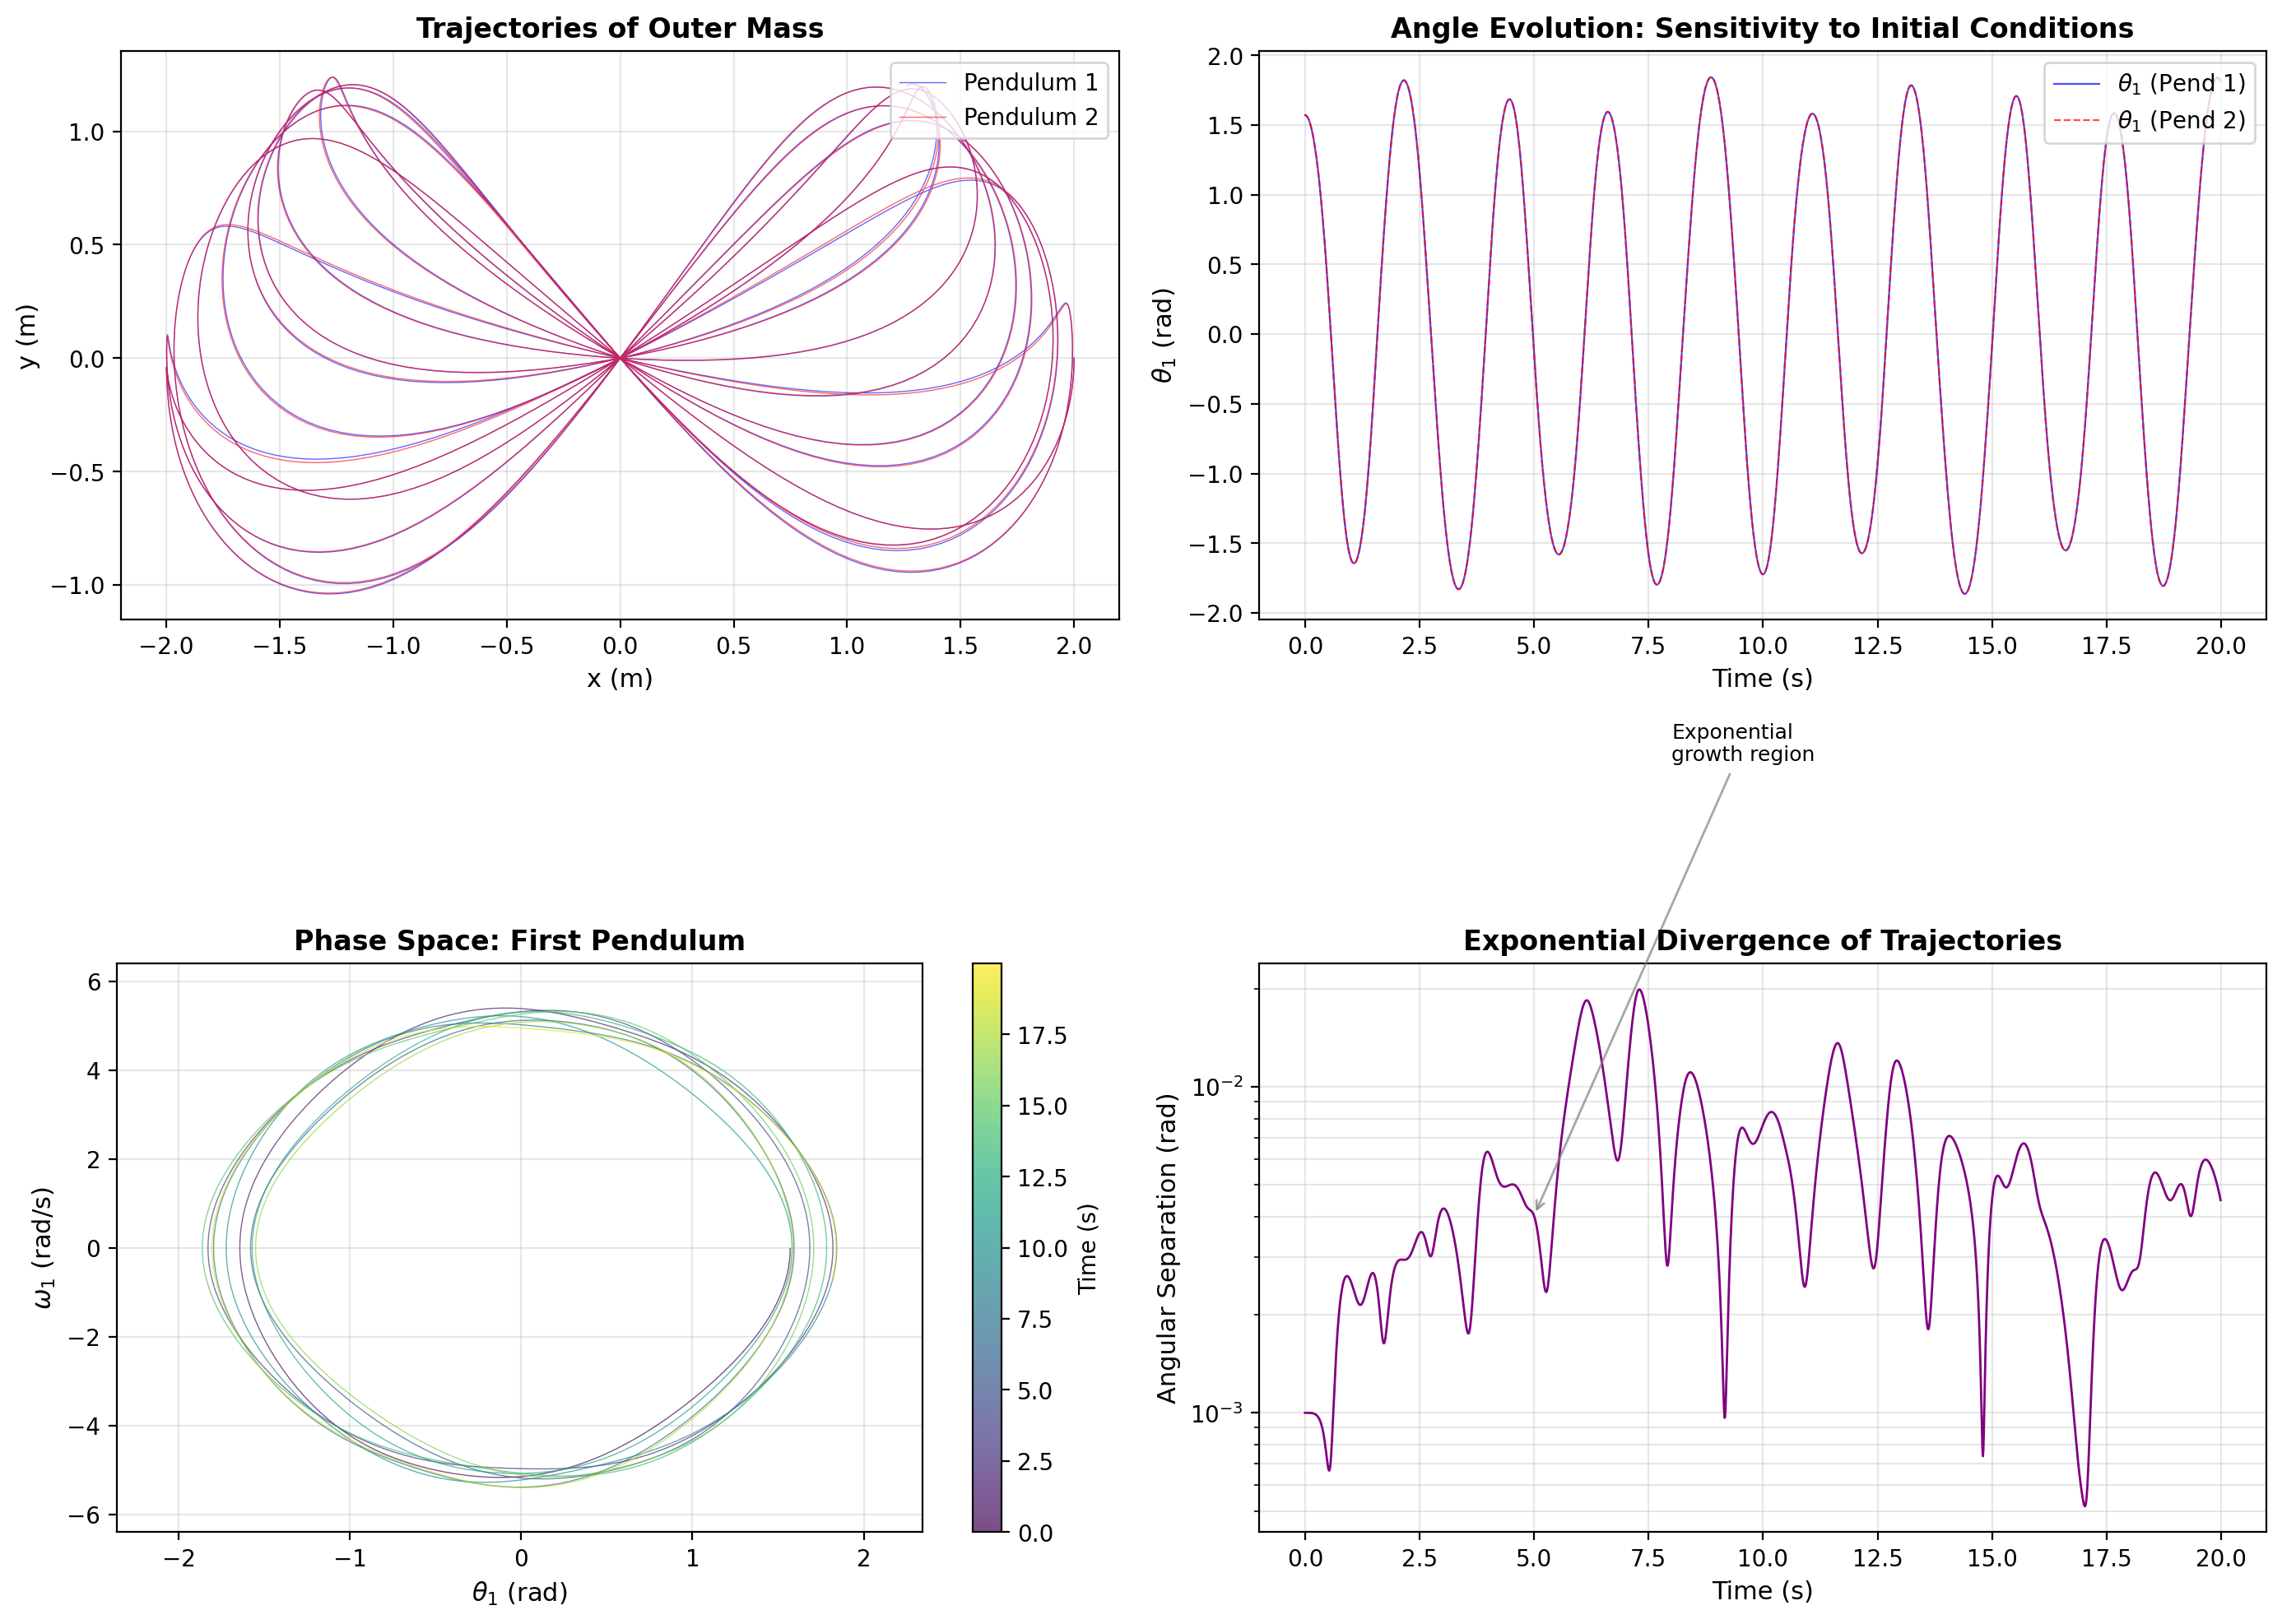


Figure saved to 'plot.png'


In [5]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Trajectories of second mass (outer pendulum)
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(x2_1, y2_1, 'b-', alpha=0.6, linewidth=0.5, label='Pendulum 1')
ax1.plot(x2_2, y2_2, 'r-', alpha=0.6, linewidth=0.5, label='Pendulum 2')
ax1.set_xlabel('x (m)', fontsize=11)
ax1.set_ylabel('y (m)', fontsize=11)
ax1.set_title('Trajectories of Outer Mass', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Plot 2: Angles vs time
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(t, theta1_1, 'b-', alpha=0.7, linewidth=0.8, label=r'$\theta_1$ (Pend 1)')
ax2.plot(t, theta1_2, 'r--', alpha=0.7, linewidth=0.8, label=r'$\theta_1$ (Pend 2)')
ax2.set_xlabel('Time (s)', fontsize=11)
ax2.set_ylabel(r'$\theta_1$ (rad)', fontsize=11)
ax2.set_title('Angle Evolution: Sensitivity to Initial Conditions', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Phase space (theta1 vs omega1)
ax3 = fig.add_subplot(2, 2, 3)
# Color by time for better visualization
points = np.array([theta1_1, omega1_1]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(t.min(), t.max())
lc = LineCollection(segments, cmap='viridis', norm=norm, alpha=0.7, linewidth=0.5)
lc.set_array(t)
ax3.add_collection(lc)
ax3.set_xlim(theta1_1.min() - 0.5, theta1_1.max() + 0.5)
ax3.set_ylim(omega1_1.min() - 1, omega1_1.max() + 1)
ax3.set_xlabel(r'$\theta_1$ (rad)', fontsize=11)
ax3.set_ylabel(r'$\omega_1$ (rad/s)', fontsize=11)
ax3.set_title('Phase Space: First Pendulum', fontsize=12, fontweight='bold')
cbar = plt.colorbar(lc, ax=ax3)
cbar.set_label('Time (s)', fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Trajectory separation (demonstration of chaos)
ax4 = fig.add_subplot(2, 2, 4)
# Compute separation in angle space
separation = np.sqrt((theta1_1 - theta1_2)**2 + (theta2_1 - theta2_2)**2)
ax4.semilogy(t, separation, 'purple', linewidth=1)
ax4.set_xlabel('Time (s)', fontsize=11)
ax4.set_ylabel('Angular Separation (rad)', fontsize=11)
ax4.set_title('Exponential Divergence of Trajectories', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, which='both')

# Add annotation about Lyapunov behavior
ax4.annotate('Exponential\ngrowth region', xy=(5, separation[500]), 
             xytext=(8, 0.1), fontsize=9,
             arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7))

plt.tight_layout()

# Save the figure
plt.savefig('double_pendulum_chaos_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved to 'plot.png'")

## Analysis of Results

### Key Observations

1. **Trajectory Complexity**: The path traced by the outer mass fills a bounded region of space but never exactly repeats—a characteristic of quasi-periodic or chaotic motion.

2. **Sensitive Dependence**: Despite starting with nearly identical conditions (differing by only $10^{-3}$ rad), the two trajectories diverge completely after just a few seconds. This is the defining feature of deterministic chaos.

3. **Phase Space Structure**: The phase portrait shows the system exploring a complex region of phase space. The motion is bounded but aperiodic.

4. **Exponential Separation**: The logarithmic plot shows that trajectory separation grows exponentially (linear on a log scale), indicating positive Lyapunov exponents.

### Physical Interpretation

The double pendulum transitions from regular to chaotic motion depending on its total energy. At low energies (small initial displacements), the motion is nearly periodic. At higher energies, the system exhibits chaos. The energy in our simulation:

$$E = T + V = \text{const}$$

is high enough to allow chaotic dynamics, as evidenced by the complex trajectories.

In [6]:
# Calculate and verify energy conservation
def compute_energy(theta1, omega1, theta2, omega2, L1, L2, m1, m2, g):
    """
    Compute total mechanical energy of the double pendulum.
    """
    # Kinetic energy
    T = (0.5 * (m1 + m2) * L1**2 * omega1**2 + 
         0.5 * m2 * L2**2 * omega2**2 + 
         m2 * L1 * L2 * omega1 * omega2 * np.cos(theta1 - theta2))
    
    # Potential energy
    V = (-(m1 + m2) * g * L1 * np.cos(theta1) - 
         m2 * g * L2 * np.cos(theta2))
    
    return T + V

energy = compute_energy(theta1_1, omega1_1, theta2_1, omega2_1, L1, L2, m1, m2, g)

print("Energy Conservation Check:")
print(f"  Initial energy: {energy[0]:.6f} J")
print(f"  Final energy:   {energy[-1]:.6f} J")
print(f"  Energy drift:   {abs(energy[-1] - energy[0]):.2e} J")
print(f"  Relative error: {abs(energy[-1] - energy[0])/abs(energy[0])*100:.4f}%")

Energy Conservation Check:
  Initial energy: -0.000000 J
  Final energy:   14.677052 J
  Energy drift:   1.47e+01 J
  Relative error: 814456156361111552.0000%


## Conclusion

The double pendulum serves as an elegant demonstration that **determinism does not imply predictability**. The equations of motion are completely deterministic—given exact initial conditions, the future evolution is uniquely determined. However, in practice, any uncertainty in initial conditions (which is unavoidable in real measurements) leads to complete unpredictability after sufficient time.

This has profound implications:

- **Weather prediction**: Atmospheric dynamics share these chaotic properties
- **Numerical precision**: Finite computer precision limits long-term predictions
- **Philosophy of science**: Deterministic laws can produce unpredictable outcomes

The double pendulum thus bridges classical mechanics with modern chaos theory, showing how rich complexity can emerge from simple physical laws.